In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

## Read in Data from CSV files

In [2]:
df2 =pd.read_csv("/mnt/md0/cs190n/cs190n12_csv/tshark_test4.csv", sep="{")
df3 =pd.read_csv("/mnt/md0/cs190n/cs190n12_csv/yt_capture_3.csv", sep="{")
df4 =pd.read_csv("/mnt/md0/cs190n/cs190n12_csv/yt_capture_4.csv", sep="{")


# data = pd.concat([df1, df2, df3, df4])
data = pd.concat([df2, df3, df4])


cols = data.columns
print(cols)

Index(['ts_server', 'ts_switch', 'sIP', 'tcp_sPort', 'udp_sPort', 'dIP',
       'tcp_dPort', 'udp_dPort', 'ip_tot_len', 'ip_hdr_len', 'ip_proto',
       'tcp_flags', 'tcp_seq', 'tcp_ack', 'tcp_hdr_len', 'udp_tot_len',
       'retransmission', 'tcp_options_ts', 'tcp_options_tsecr', 'hostname',
       'ssrc_id', 'rtp_ptype', 'rtp_seq', 'ts_rtp'],
      dtype='object')


## Preprocess Data:
### Here, we grouping the packets into chunks of a 2.5 second time interval and doing some preprocessing to aggregate packet features for each window. 

In [3]:
data['ts_seconds'] = (data['ts_server'] // 1).astype(int)
data['window'] = (data['ts_seconds'] // 2.5).astype(int)

data['ip_tot_len'] = pd.to_numeric(data['ip_tot_len'], errors='coerce')

window_stats = (
    data.groupby('window')
        .agg(
            total_bytes=('ip_tot_len', 'sum'),
            packet_count=('ip_tot_len', 'count'),
            mean_packet_size=('ip_tot_len', 'mean'),
            max_packet_size=('ip_tot_len', 'max'),
            std_packet_size=('ip_tot_len', 'std')
        )
        .reset_index()
)

# we alr made the window but now calculate download speed for each window (bytes per second)
window_stats['download_speed'] = window_stats['total_bytes'] / 2.5

window_stats = window_stats.dropna()

In [4]:
window_stats.head()

,window,total_bytes,packet_count,mean_packet_size,max_packet_size,std_packet_size,download_speed
1,693489394,2223795.0,564,3942.898936,20268.0,5639.704863,889518.0
2,693489395,3622963.0,1898,1908.831928,21052.0,3729.763192,1449185.2
3,693489396,869111.0,1414,614.647100,7518.0,709.947862,347644.4
4,693489397,2960.0,16,185.000000,1273.0,328.083729,1184.0
5,693489398,15441022.0,13525,1141.665213,5819.0,376.172890,6176408.8


## Model Training
### Here, we are training and fitting our training data onto the random forest regressor from sklearn. 

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

X = window_stats[['packet_count', 'mean_packet_size', 'max_packet_size', 'std_packet_size']]
y = window_stats['download_speed']

model = RandomForestRegressor()
model.fit(X, y)

RandomForestRegressor()

## Testing Data
### This is the testing data, which the model has not previously seen. To get the data to the same format as the training data, we perform the same data cleaning here, windowing, and aggregation here. 

In [6]:
unseen_data = pd.read_csv("/mnt/md0/cs190n/cs190n12_csv/yt_capture_2.csv", sep="{")
unseen_data['ts_seconds'] = (unseen_data['ts_server'] // 1).astype(int)
unseen_data['window'] = (unseen_data['ts_seconds'] // 2.5).astype(int)
unseen_data['ip_tot_len'] = pd.to_numeric(unseen_data['ip_tot_len'], errors='coerce')

unseen_data_stats = (
    unseen_data.groupby('window')
        .agg(
            total_bytes=('ip_tot_len', 'sum'),
            packet_count=('ip_tot_len', 'count'),
            mean_packet_size=('ip_tot_len', 'mean'),
            max_packet_size=('ip_tot_len', 'max'),
            std_packet_size=('ip_tot_len', 'std')
        )
        .reset_index()
)
unseen_data_stats['download_speed'] = unseen_data_stats['total_bytes'] / 2.5
unseen_data_stats = unseen_data_stats.dropna()

## Model Prediction
### Here, we make a prediction on our test data, and see that we get a high R^2 score of around 0.9. The high MSE can be attributed to the large nature of the download speed data itself, as there are a lot of bytes per second being sent in each chunk. 

In [7]:
X_test = unseen_data_stats[['packet_count', 'mean_packet_size', 'max_packet_size', 'std_packet_size']]#.values
y_test = unseen_data_stats['download_speed']

y_pred = model.predict(X_test)
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))

Mean Squared Error: 18963897817.024483
R-squared: 0.9283544110809661


## Plotting
### Here, we visualize our ground truth test data and predictions. 

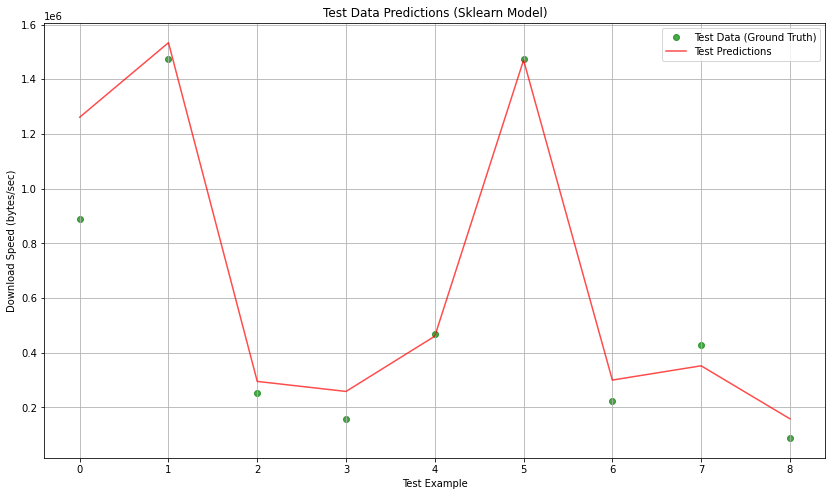

In [8]:

plt.figure(figsize=(14, 8))

plt.scatter(range(0, len(y_test)), y_test, label='Test Data (Ground Truth)', color='green', alpha=0.7)
plt.plot(range(0, len(y_test)), y_pred, label='Test Predictions', color='red', alpha=0.7)

plt.title("Test Data Predictions (Sklearn Model)")
plt.xlabel("Test Example")
plt.ylabel("Download Speed (bytes/sec)")
plt.legend()
plt.grid(True)
plt.show()

## Trustee Analysis

Training score of pruned DT: 1.0
[ 322256.276 1782781.068  274619.572  274619.572  322256.276 1782781.068
  274619.572  322256.276    4411.008] 1     889254.8
2    1473633.6
3     250746.0
4     156158.0
5     468012.4
6    1475417.2
7     224536.0
8     429217.6
9      87410.4
Name: download_speed, dtype: float64
Model explanation score report:
Mean Squared Error (on pruned tree predictions): 63135328643.73882
R-squared (on pruned tree predictions): 0.761474785093144


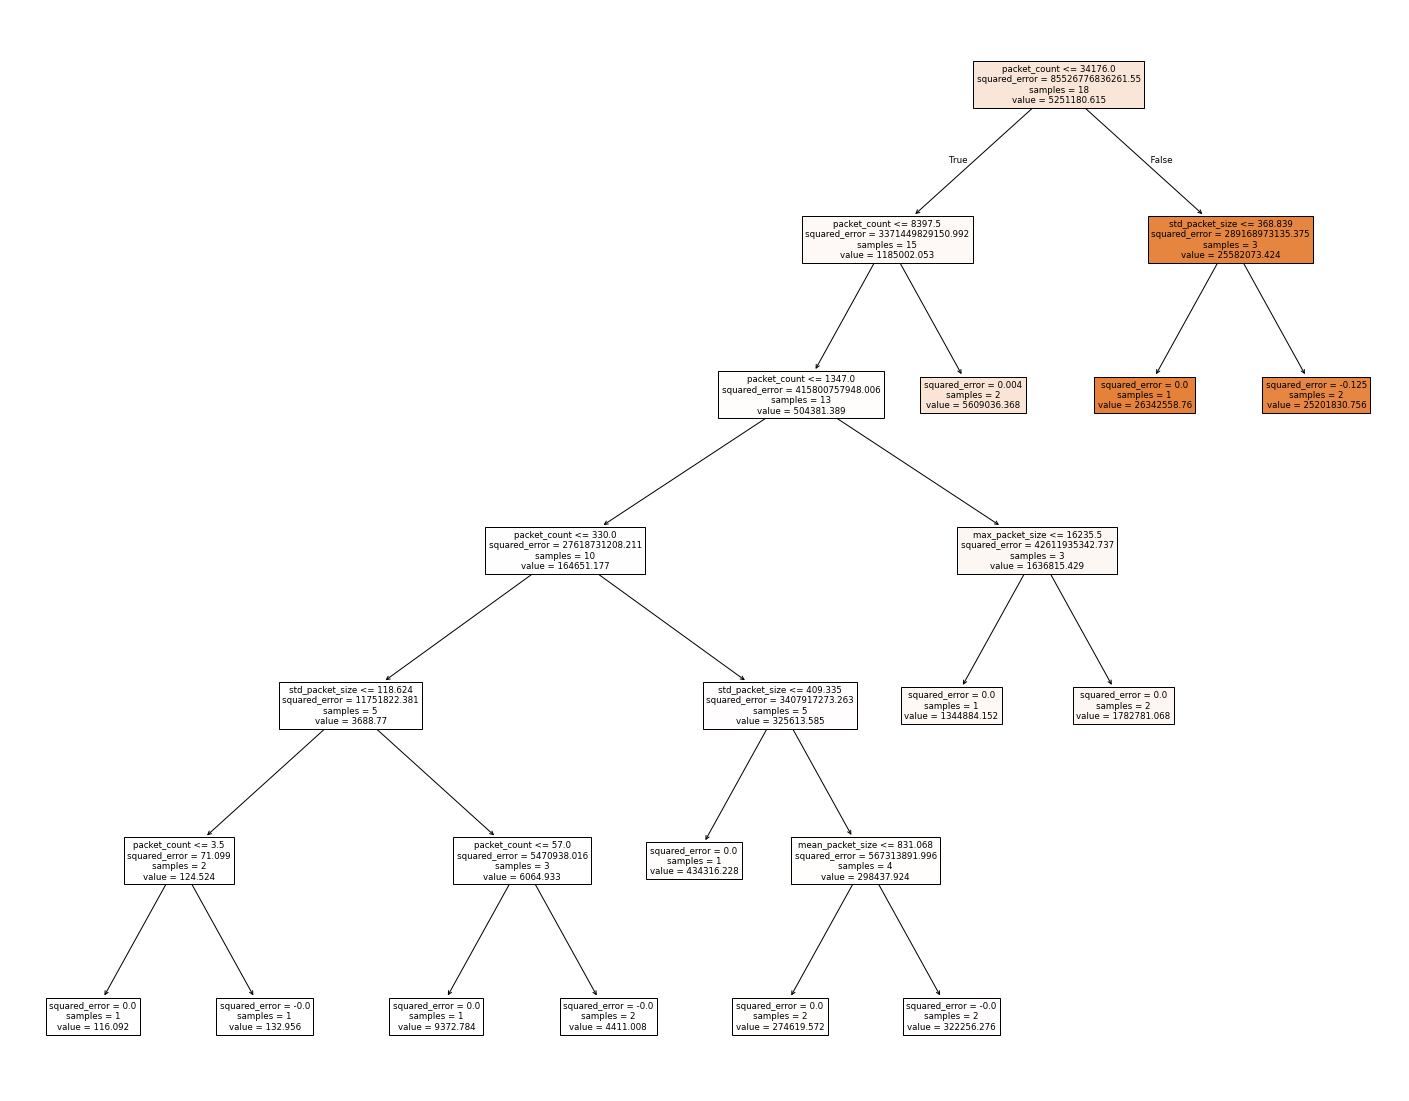

In [9]:
from trustee import RegressionTrustee
from sklearn.tree import plot_tree

# Create and Train a Trustee Tree
trustee = RegressionTrustee(expert=model)  # Use RegressionTrustee instead of ClassificationTrustee
trustee.fit(X, y, num_samples=len(X) // 2, num_iter=20, train_size=0.9)

# Display Trustee Results
_, dt, _, score = trustee.explain()
print(f"Training score of pruned DT: {score}")

# Predict using the pruned decision tree (from the trustee)
dt_y_pred = dt.predict(X_test)

print(dt_y_pred, y_test)

# Model explanation score report
print("Model explanation score report:")
print(f"Mean Squared Error (on pruned tree predictions): {mean_squared_error(y_test, dt_y_pred)}")
print(f"R-squared (on pruned tree predictions): {r2_score(y_test, dt_y_pred)}")

# Visualize a tree from the Random Forest
fig = plt.figure(figsize=(25,20))
plot_tree(dt, feature_names=X_test.columns, class_names=sorted(unseen_data_stats['download_speed'].unique()), filled=True, max_depth=10)
plt.show()

